# Do Not Overfit Challenge

#### Kaggle recently launched a challenge to run classification models on datasets with a very particular goal - do not overfit!!

#### Datasets had only 250 rows and features around 320. Since our number of independent features is greater than sample size, we are faced with a very pressing overfitting challenge.

##### Below I enumerate the methodology to reduce overfitting :

###### 1. Reduce feature size using two specific techniques: pearsons  correlation coefficient and dimensionality reduction techniques
###### 2. Create handful of samples with goal on simplicity. eg less number of estimators,less number of iterations etc
###### 3. Provide regularization parameters where applicable
###### 4. Plot precision-recall curves and roc-auc curves for each model. Check learning curve as well.
###### 5. Use StratifiedKFold cross validation to parameter tune
###### 6. Deal with imbalance in target classes using under sampling and over sampling techniques



Note: baseline model creation(using all features + regularization + tsne dimensionality reduction + over/under sampling) technique provided no real use. CV scores for roc auc did not exceed 0.6 in every scenario possible.






In [1]:
import numpy as np
import pandas as panda
from matplotlib import pyplot as plot
import seaborn as sns

import pandas as panda
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,\
    StratifiedKFold,GridSearchCV,RepeatedStratifiedKFold,learning_curve, cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier,SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif,f_classif
from numpy import bincount, linspace, mean, std, arange, squeeze

from keras.models import Sequential
from keras.layers import Dense, Activation, GaussianNoise,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras import regularizers
import warnings

warnings.simplefilter('ignore')
%matplotlib inline


C:\Users\somak\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(143)

In [3]:
train_data = panda.read_csv('data/train.csv')


In [4]:
train_data.target.value_counts(), train_data.shape

(1.0    160
 0.0     90
 Name: target, dtype: int64, (250, 302))

In [7]:
train_data['target'] = train_data.target.astype(np.int64)

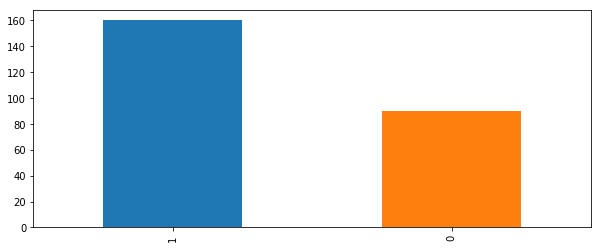

In [8]:
plot.figure(figsize=(10,4))
train_data.target.value_counts().plot(kind='bar')
plot.show()

In [9]:
train_data[[i for i in train_data.columns.tolist() if i not in ['target','id']]].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
0,250.0,0.023292,0.998354,-2.319,-0.64475,-0.0155,0.67700,2.567
1,250.0,-0.026872,1.009314,-2.931,-0.73975,0.0570,0.62075,2.419
2,250.0,0.167404,1.021709,-2.477,-0.42525,0.1840,0.80500,3.392
3,250.0,0.001904,1.011751,-2.359,-0.68650,-0.0165,0.72000,2.771
4,250.0,0.001588,1.035411,-2.566,-0.65900,-0.0230,0.73500,2.901
5,250.0,-0.007304,0.955700,-2.845,-0.64375,0.0375,0.66050,2.793
6,250.0,0.032052,1.006657,-2.976,-0.67500,0.0605,0.78325,2.546
7,250.0,0.078412,0.939731,-3.444,-0.55075,0.1835,0.76625,2.846
8,250.0,-0.036920,0.963688,-2.768,-0.68950,-0.0125,0.63500,2.512
9,250.0,0.035448,1.019689,-2.361,-0.64350,0.0520,0.73300,2.959


In [10]:
data_type = train_data.dtypes.to_frame().reset_index()
data_type.columns  = ['col_name','col_type']
data_type[data_type.col_type==np.object].head()

,col_name,col_type


In [11]:
train_data.isnull().any().sum()

0

In [12]:
col_names = [i for i in train_data.columns if i not in ['target','id']]

In [13]:
from scipy import stats
def calculateCorrelationCoefficientsAndpValues(x_data, y_data, xlabel):
    
    pearson_coef, p_value = stats.pearsonr(x_data, y_data)
    print("The Pearson Correlation Coefficient for %s is %s with a P-value of P = %s" %(xlabel,pearson_coef, p_value))
    
    return (pearson_coef,p_value)

In [14]:
pearson_coeff = []
p_value = []
col_name = []

for col in [i for i in train_data.columns.tolist() if i not in ['id','target']]:
    
    x,y = calculateCorrelationCoefficientsAndpValues(train_data[col], train_data['target'], col)
    pearson_coeff.append(x)
    p_value.append(y)
    col_name.append(col)
    
pearson_table = panda.DataFrame({'column_name':col_name , 'pearson_coeff':pearson_coeff, 'p_value': p_value})
pearson_table.head()

The Pearson Correlation Coefficient for 0 is 0.10896613295780612 with a P-value of P = 0.0855425108978631
The Pearson Correlation Coefficient for 1 is -0.07331927684495224 with a P-value of P = 0.2480801859987947
The Pearson Correlation Coefficient for 2 is -0.015140943820013032 with a P-value of P = 0.8117157095966047
The Pearson Correlation Coefficient for 3 is 0.011549011379043529 with a P-value of P = 0.8558206568804985
The Pearson Correlation Coefficient for 4 is -0.11472596336421398 with a P-value of P = 0.07016102972091894
The Pearson Correlation Coefficient for 5 is -0.05032883942137733 with a P-value of P = 0.42819565779211044
The Pearson Correlation Coefficient for 6 is -0.05706281139477776 with a P-value of P = 0.36894411376906777
The Pearson Correlation Coefficient for 7 is 0.0042391278386217585 with a P-value of P = 0.9468277872565647
The Pearson Correlation Coefficient for 8 is -0.04844250987759829 with a P-value of P = 0.44573026468867594
The Pearson Correlation Coeffici

,column_name,pearson_coeff,p_value
0,0,0.108966,0.085543
1,1,-0.073319,0.248080
2,2,-0.015141,0.811716
3,3,0.011549,0.855821
4,4,-0.114726,0.070161


In [15]:
pearson_table[(pearson_table.pearson_coeff>0.1) | (pearson_table.pearson_coeff<-0.1)].sort_values(by=['pearson_coeff'], ascending=False)

,column_name,pearson_coeff,p_value
33,33,0.373608,1.060808e-09
65,65,0.293846,2.271695e-06
24,24,0.173096,6.071028e-03
183,183,0.164146,9.321805e-03
199,199,0.159442,1.158492e-02
201,201,0.142238,2.450232e-02
30,30,0.132705,3.599201e-02
289,289,0.127213,4.448368e-02
114,114,0.124792,4.872907e-02
164,164,0.124151,4.990705e-02


In [16]:
reqd_columns = pearson_table[(pearson_table.pearson_coeff>0.1) | (pearson_table.pearson_coeff<-0.1)].sort_values(by=['pearson_coeff'], ascending=False).column_name.values.tolist()
reqd_columns[:5], len(reqd_columns)

(['33', '65', '24', '183', '199'], 50)

There are a couple of observations that we can make out of the above diagrams:

1. ALmost all independent variables are distributed within -2.5 and 2.5
2. Almost all have near normal distributions
3. Almost none have any significant outliers
4. Pearsons correlation coeff for each indedepent variable with target variable is pretty low
5. There are no categorical data
6. pearsons correlation coefficient scores are pretty less and we will take all whose scores are above 0.1 and below -0.1

#### Based on above data analysis, we are going to attempt 3 things

1. create a baseline model out of gridsearch for the data using the usual suspects of classifiers. 


2. Plot learning curve and auc/roc scores for each


3. try dimensionality reduction techniques such as PCA,LDA and t-SNE and run on baseline models created in step 1.


4. try SMOTE and run on the same model created in point 1 and compare scores



### STEP 1: Run handful of usual suspect classifiers using selected 50 features giving highest coeff scores

<br><br>

In [17]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [19]:

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  model_name, k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes for model:"+model_name)
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
def plot_roc_auc_curve(false_positive_rate, true_positive_rate, model_name):
        
    plot.figure(figsize=(10,3))
    plot.plot(list(false_positive_rate), list(true_positive_rate),  label = "ROC Curve for model: "+model_name)     
    plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
    plot.plot([0, 0, 1], [0,1, 1], ':', label = 'Perfect Score')
    auc_score = auc(false_positive_rate, true_positive_rate)
    plot.title('ROC Curve for model: %s with AUC %.2f'%(model_name, auc_score))
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.legend(loc='best')
    plot.show()
    
    
def plot_precision_recall_curve(precision, recall, model_name):
    
    plot.figure(figsize=(10,3))
    plot.plot(list(recall), list(precision),  label = "Precision/Recall Curve for model: "+model_name)     
#     plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing') #
    plot.title('Precision Recall Curve for model: %s'%model_name)
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.legend(loc='best')
    plot.show()


    


In [20]:
def runGridSearchAndPredict(pipeline,model_name, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
#     pass

    response =  {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(x_train, y_train, search.best_estimator_, model_name)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = y_test ,y_pred = y_prediction, labels = list(set(y_test)))
        classes = list(set(y_test))
        plot_confusion_matrix(_matrix, classes, title = "Confusion matrix for model:"+model_name)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(x_test)
            number_of_classes = len(np.unique(y_train))
            false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:, 1])
            response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
            response['roc_curve'] = (false_positive_rate, true_positive_rate)  
            response['roc_curve_false_positive_rate'] = false_positive_rate
            response['roc_curve_true_positive_rate'] = true_positive_rate
            precision, recall, _ = precision_recall_curve(y_test, y_probability[:,1])
            plot_roc_auc_curve(false_positive_rate, true_positive_rate, model_name)
            plot_precision_recall_curve(precision, recall, model_name)
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = 0
            response['roc_curve_false_positive_rate'] = 0
            response['roc_curve_true_positive_rate'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


def plotROCCurveAcrossModels(positive_rates_sequence, model_name):
    
    plot.figure(figsize=(10,5))
    for plot_values, label_name in zip(positive_rates_sequence, model_name):
        
        plot.plot(list(plot_values[0]), list(plot_values[1]),  label = "ROC Curve for model: "+label_name)
        
    plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing') #
    plot.title('ROC Curve across models')
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.legend(loc='best')
    plot.show()

In [21]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline_steps = [('scaler', scaler),(model_name, model)] if scaler is not None else [(model_name, model)]
            pipeline = Pipeline(pipeline_steps)

            result = runGridSearchAndPredict(pipeline, 
                                             model_name,
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = score)

            _y_prediction = result['_y_prediction']

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_score'] = result.get('roc_auc_score')
            model_metrics[model_name]['roc_curve_true_positive_rate'] = result.get('roc_curve_true_positive_rate')
            model_metrics[model_name]['roc_curve_false_positive_rate'] = result.get('roc_curve_false_positive_rate')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')


    print(timer.took)
    
    return model_metrics


In [22]:

classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    LogisticRegression(random_state = 1, solver='liblinear'),
    LogisticRegression(random_state = 1, solver='newton-cg'),
    LogisticRegression(random_state = 1, solver='sag'),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel="linear"),
    SVC(),
    ExtraTreeClassifier(random_state = 123),
    GaussianProcessClassifier(random_state = 123),
    BernoulliNB(),
    BaggingClassifier(base_estimator = LogisticRegression(random_state = 1)),
    BaggingClassifier(base_estimator = BernoulliNB()),
    GradientBoostingClassifier(random_state= 123),
    LGBMClassifier(objective = 'binary'),
    XGBClassifier(objective = 'binary:logistic')
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'logisticregression_liblinear_l2',
            'logisticregression_newton_cg',
            'logisticregression_sag',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'linear_svc',
            'gamma_svc',
            'extra_trees',
            'gaussian_process',
            'bernoulli',
            'bagging_logistic',
            'bagging_bernoulli',
            'gradient_boosting_classifier',
            'lgbm_classifier',
            'xgb'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {
             'logisticregression__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression__penalty':['l1','l2'],
             'logisticregression__solver':['saga','liblinear']
            },
            {
             'logisticregression_liblinear_l2__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_liblinear_l2__penalty':['l2'],
             'logisticregression_liblinear_l2__dual':[True]
            },
            {
             'logisticregression_newton_cg__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_newton_cg__penalty':['l2'],
            },
            {
             'logisticregression_sag__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_sag__penalty':['l2'],
            },
    
            {'decisiontreeclassifier__max_depth':[6,8,10],
             'decisiontreeclassifier__criterion':['gini','entropy'],
             'decisiontreeclassifier__max_features':['auto','sqrt','log2'],
            },
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini','entropy']} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'linear_svc__C':[0.025]},
            {'gamma_svc__gamma':[2,4],'gamma_svc__C':[1,5]},
            {'extra_trees__max_depth':[6,8,12],'extra_trees__criterion': ['gini','entropy']} ,
            {'gaussian_process__max_iter_predict':[200,400]} ,
            {'bernoulli__alpha':[0.2,0.6,1.2]} ,
            {'bagging_logistic__base_estimator__C':[1.2,0.02,2.2,4], 
             'bagging_logistic__base_estimator__penalty':['l1','l2'],
             'bagging_logistic__n_estimators': [5,8,10]
            },
            {'bagging_bernoulli__base_estimator__alpha':[1.2,0.02,2.2,4], 
             'bagging_bernoulli__n_estimators': [5,8,10]
            },
            {
                'gradient_boosting_classifier__loss':['deviance','exponential'],
                'gradient_boosting_classifier__learning_rate':[0.5,1.2],
                'gradient_boosting_classifier__n_estimators':[100,500,1000],
                'gradient_boosting_classifier__criterion':['friedman_mse','mse','mae'],
                'gradient_boosting_classifier__max_depth':[6,8,16,20],
            },
            {
                 'lgbm_classifier__num_leaves':[25,], \
#                  'lgbm_classifier__min_data_in_leaf':[20],\
                 'lgbm_classifier__max_depth':[20,], \
                 'lgbm_classifier__learning_rate' : [0.01,],\
                 'lgbm_classifier__min_child_samples' :[2,], \
                 'lgbm_classifier__n_estimators' : [5000,], \
                 'lgbm_classifier__num_boost_round' : [100], \
                 'lgbm_classifier__feature_fraction' : [0.9,], \
                 'lgbm_classifier__bagging_freq' : [1,], \
                 'lgbm_classifier__bagging_seed' : [123], \
            },
             {
                'xgb__max_depth':[6,8,10],
                 'xgb__learning_rate':[0.1,0.5,1,2],
                 'xgb__n_estimators':[100,400,1000],             
                 'xgb__booster':['gbtree','dart'],
                 'xgb__subsample':[0.5, 0.2,0.8]
            },
    
]


In [24]:
# x = train_data[[i for i in train_data.columns.tolist() if i not in ['target','id']]]
x = train_data[reqd_columns[:51]]
# x = train_data[anova_columns]
y = train_data['target']

x_train,x_test,y_train,y_test = train_test_split(x,y , stratify = y, test_size = 0.3, random_state = 123)

In [25]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'roc_auc'

In [26]:
input_shape = x_train.shape[1]

def prepare_classifier(noise_level = 0.01, input_shape = input_shape, dropout_rate = 0.2, l2_penalty = 0.02, l1_penalty= 0.01):
    
    kernel_regularizer = regularizers.l2(l2_penalty)
    activity_regularizer = regularizers.l1(l1_penalty)
    
    model = Sequential()
#     model.add(GaussianNoise(noise_level, input_shape = (input_shape,)))
    model.add(Dense(250, activation='relu', input_dim = input_shape, kernel_regularizer=kernel_regularizer, activity_regularizer = activity_regularizer))
#     model.add(GaussianNoise(noise_level))
#     model.add(Dropout(rate = dropout_rate))
    
    model.add(Dense(250, activation='relu', kernel_regularizer=kernel_regularizer, activity_regularizer = activity_regularizer))
#     model.add(Dropout(rate = dropout_rate))  
#     model.add(GaussianNoise(noise_level))              
    model.add(Dense(1, activation='softmax'))
    

    optimizer = Adam(0.01)
#     optimizer = RMSprop(0.001)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    
    return model


keras_classifier = KerasClassifier(build_fn = prepare_classifier)

In [27]:
_es_monitor = 'val_loss'
_es_patience = 50
es = EarlyStopping(monitor=_es_monitor, mode='min', verbose=1, patience=_es_patience)

In [28]:
from keras.utils import to_categorical

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

tl = TomekLinks(return_indices=True, ratio='majority')
_x_train_tomek, _y_train_tomek, id_tl = tl.fit_sample(x, y)

smt = SMOTETomek(ratio='auto')
_x_train_smt, _y_train_smt = smt.fit_sample(x, y)

smote = SMOTE(ratio='minority')
x_train_smote, y_train_smote = smote.fit_sample(x,y)





In [79]:


x = train_data[col_names]
model = prepare_classifier(dropout_rate=.25, input_shape=x.shape[1])


for train_index, test_index in cv.split(x, y):

    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    smt = SMOTETomek(ratio=1)
    _x_train_smt, _y_train_smt = smt.fit_sample(x_train, y_train)
    history = model.fit(_x_train_smt, \
                        _y_train_smt, \
                        validation_data=(x_test,y_test),
                        epochs=500, \
                        batch_size = len(_x_train_smt), \
                        verbose=1, \
                        shuffle=True ,\
                        callbacks=[es],
#                         class_weight = {0:.2,1:.6}
                       )

Train on 256 samples, validate on 50 samples
Epoch 1/500
256/256 [==============================] - 1s 3ms/step - loss: 447.3546 - acc: 0.5000 - val_loss: 97.7166 - val_acc: 0.6400
Epoch 2/500
256/256 [==============================] - 0s 32us/step - loss: 414.4879 - acc: 0.5000 - val_loss: 91.6491 - val_acc: 0.6400
Epoch 3/500
256/256 [==============================] - 0s 34us/step - loss: 375.6239 - acc: 0.5000 - val_loss: 86.4345 - val_acc: 0.6400
Epoch 4/500
256/256 [==============================] - 0s 24us/step - loss: 342.4466 - acc: 0.5000 - val_loss: 82.0395 - val_acc: 0.6400
Epoch 5/500
256/256 [==============================] - 0s 52us/step - loss: 314.2857 - acc: 0.5000 - val_loss: 78.3738 - val_acc: 0.6400
Epoch 6/500
256/256 [==============================] - 0s 42us/step - loss: 290.3719 - acc: 0.5000 - val_loss: 75.3212 - val_acc: 0.6400
Epoch 7/500
256/256 [==============================] - 0s 33us/step - loss: 270.1113 - acc: 0.5000 - val_loss: 72.8602 - val_acc: 0.64

Epoch 61/500
256/256 [==============================] - 0s 43us/step - loss: 34.9343 - acc: 0.5000 - val_loss: 52.8898 - val_acc: 0.6400
Epoch 62/500
256/256 [==============================] - 0s 44us/step - loss: 33.7549 - acc: 0.5000 - val_loss: 52.7823 - val_acc: 0.6400
Epoch 63/500
256/256 [==============================] - 0s 45us/step - loss: 32.6316 - acc: 0.5000 - val_loss: 52.6782 - val_acc: 0.6400
Epoch 64/500
256/256 [==============================] - 0s 42us/step - loss: 31.5593 - acc: 0.5000 - val_loss: 52.5770 - val_acc: 0.6400
Epoch 65/500
256/256 [==============================] - 0s 54us/step - loss: 30.5301 - acc: 0.5000 - val_loss: 52.4800 - val_acc: 0.6400
Epoch 66/500
256/256 [==============================] - 0s 64us/step - loss: 29.5551 - acc: 0.5000 - val_loss: 52.3863 - val_acc: 0.6400
Epoch 67/500
256/256 [==============================] - 0s 53us/step - loss: 28.6263 - acc: 0.5000 - val_loss: 52.2957 - val_acc: 0.6400
Epoch 68/500
256/256 [===================

Epoch 121/500
256/256 [==============================] - 0s 21us/step - loss: 16.1685 - acc: 0.5000 - val_loss: 49.3936 - val_acc: 0.6400
Epoch 122/500
256/256 [==============================] - 0s 32us/step - loss: 16.1557 - acc: 0.5000 - val_loss: 49.3485 - val_acc: 0.6400
Epoch 123/500
256/256 [==============================] - 0s 35us/step - loss: 16.1429 - acc: 0.5000 - val_loss: 49.3031 - val_acc: 0.6400
Epoch 124/500
256/256 [==============================] - 0s 34us/step - loss: 16.1300 - acc: 0.5000 - val_loss: 49.2578 - val_acc: 0.6400
Epoch 125/500
256/256 [==============================] - 0s 39us/step - loss: 16.1171 - acc: 0.5000 - val_loss: 49.2125 - val_acc: 0.6400
Epoch 126/500
256/256 [==============================] - 0s 60us/step - loss: 16.1042 - acc: 0.5000 - val_loss: 49.1671 - val_acc: 0.6400
Epoch 127/500
256/256 [==============================] - 0s 58us/step - loss: 16.0912 - acc: 0.5000 - val_loss: 49.1217 - val_acc: 0.6400
Epoch 128/500
256/256 [===========

Epoch 181/500
256/256 [==============================] - 0s 36us/step - loss: 15.3673 - acc: 0.5000 - val_loss: 46.5192 - val_acc: 0.6400
Epoch 182/500
256/256 [==============================] - 0s 39us/step - loss: 15.3536 - acc: 0.5000 - val_loss: 46.4686 - val_acc: 0.6400
Epoch 183/500
256/256 [==============================] - 0s 38us/step - loss: 15.3400 - acc: 0.5000 - val_loss: 46.4181 - val_acc: 0.6400
Epoch 184/500
256/256 [==============================] - 0s 43us/step - loss: 15.3263 - acc: 0.5000 - val_loss: 46.3676 - val_acc: 0.6400
Epoch 185/500
256/256 [==============================] - 0s 40us/step - loss: 15.3127 - acc: 0.5000 - val_loss: 46.3170 - val_acc: 0.6400
Epoch 186/500
256/256 [==============================] - 0s 39us/step - loss: 15.2991 - acc: 0.5000 - val_loss: 46.2662 - val_acc: 0.6400
Epoch 187/500
256/256 [==============================] - 0s 35us/step - loss: 15.2854 - acc: 0.5000 - val_loss: 46.2151 - val_acc: 0.6400
Epoch 188/500
256/256 [===========

Epoch 241/500
256/256 [==============================] - 0s 38us/step - loss: 14.5528 - acc: 0.5000 - val_loss: 43.4212 - val_acc: 0.6400
Epoch 242/500
256/256 [==============================] - 0s 45us/step - loss: 14.5393 - acc: 0.5000 - val_loss: 43.3689 - val_acc: 0.6400
Epoch 243/500
256/256 [==============================] - 0s 53us/step - loss: 14.5258 - acc: 0.5000 - val_loss: 43.3165 - val_acc: 0.6400
Epoch 244/500
256/256 [==============================] - 0s 42us/step - loss: 14.5125 - acc: 0.5000 - val_loss: 43.2641 - val_acc: 0.6400
Epoch 245/500
256/256 [==============================] - 0s 39us/step - loss: 14.4991 - acc: 0.5000 - val_loss: 43.2118 - val_acc: 0.6400
Epoch 246/500
256/256 [==============================] - 0s 54us/step - loss: 14.4857 - acc: 0.5000 - val_loss: 43.1594 - val_acc: 0.6400
Epoch 247/500
256/256 [==============================] - 0s 43us/step - loss: 14.4724 - acc: 0.5000 - val_loss: 43.1070 - val_acc: 0.6400
Epoch 248/500
256/256 [===========

Epoch 301/500
256/256 [==============================] - 0s 79us/step - loss: 13.7671 - acc: 0.5000 - val_loss: 40.2570 - val_acc: 0.6400
Epoch 302/500
256/256 [==============================] - 0s 52us/step - loss: 13.7544 - acc: 0.5000 - val_loss: 40.2038 - val_acc: 0.6400
Epoch 303/500
256/256 [==============================] - 0s 28us/step - loss: 13.7417 - acc: 0.5000 - val_loss: 40.1507 - val_acc: 0.6400
Epoch 304/500
256/256 [==============================] - 0s 30us/step - loss: 13.7290 - acc: 0.5000 - val_loss: 40.0971 - val_acc: 0.6400
Epoch 305/500
256/256 [==============================] - 0s 25us/step - loss: 13.7164 - acc: 0.5000 - val_loss: 40.0440 - val_acc: 0.6400
Epoch 306/500
256/256 [==============================] - 0s 29us/step - loss: 13.7038 - acc: 0.5000 - val_loss: 39.9906 - val_acc: 0.6400
Epoch 307/500
256/256 [==============================] - 0s 38us/step - loss: 13.6911 - acc: 0.5000 - val_loss: 39.9375 - val_acc: 0.6400
Epoch 308/500
256/256 [===========

Epoch 361/500
256/256 [==============================] - 0s 41us/step - loss: 13.0335 - acc: 0.5000 - val_loss: 37.1316 - val_acc: 0.6400
Epoch 362/500
256/256 [==============================] - 0s 56us/step - loss: 13.0218 - acc: 0.5000 - val_loss: 37.0807 - val_acc: 0.6400
Epoch 363/500
256/256 [==============================] - 0s 56us/step - loss: 13.0102 - acc: 0.5000 - val_loss: 37.0299 - val_acc: 0.6400
Epoch 364/500
256/256 [==============================] - 0s 49us/step - loss: 12.9985 - acc: 0.5000 - val_loss: 36.9791 - val_acc: 0.6400
Epoch 365/500
256/256 [==============================] - 0s 55us/step - loss: 12.9868 - acc: 0.5000 - val_loss: 36.9281 - val_acc: 0.6400
Epoch 366/500
256/256 [==============================] - 0s 35us/step - loss: 12.9752 - acc: 0.5000 - val_loss: 36.8775 - val_acc: 0.6400
Epoch 367/500
256/256 [==============================] - 0s 43us/step - loss: 12.9636 - acc: 0.5000 - val_loss: 36.8272 - val_acc: 0.6400
Epoch 368/500
256/256 [===========

Epoch 421/500
256/256 [==============================] - 0s 48us/step - loss: 12.3627 - acc: 0.5000 - val_loss: 34.1249 - val_acc: 0.6400
Epoch 422/500
256/256 [==============================] - 0s 49us/step - loss: 12.3522 - acc: 0.5000 - val_loss: 34.0750 - val_acc: 0.6400
Epoch 423/500
256/256 [==============================] - 0s 47us/step - loss: 12.3416 - acc: 0.5000 - val_loss: 34.0253 - val_acc: 0.6400
Epoch 424/500
256/256 [==============================] - 0s 43us/step - loss: 12.3310 - acc: 0.5000 - val_loss: 33.9757 - val_acc: 0.6400
Epoch 425/500
256/256 [==============================] - 0s 30us/step - loss: 12.3205 - acc: 0.5000 - val_loss: 33.9261 - val_acc: 0.6400
Epoch 426/500
256/256 [==============================] - 0s 23us/step - loss: 12.3099 - acc: 0.5000 - val_loss: 33.8763 - val_acc: 0.6400
Epoch 427/500
256/256 [==============================] - 0s 27us/step - loss: 12.2994 - acc: 0.5000 - val_loss: 33.8269 - val_acc: 0.6400
Epoch 428/500
256/256 [===========

256/256 [==============================] - 0s 42us/step - loss: 11.7693 - acc: 0.5000 - val_loss: 31.2828 - val_acc: 0.6400
Epoch 481/500
256/256 [==============================] - 0s 53us/step - loss: 11.7598 - acc: 0.5000 - val_loss: 31.2366 - val_acc: 0.6400
Epoch 482/500
256/256 [==============================] - 0s 51us/step - loss: 11.7504 - acc: 0.5000 - val_loss: 31.1908 - val_acc: 0.6400
Epoch 483/500
256/256 [==============================] - 0s 46us/step - loss: 11.7410 - acc: 0.5000 - val_loss: 31.1451 - val_acc: 0.6400
Epoch 484/500
256/256 [==============================] - 0s 63us/step - loss: 11.7314 - acc: 0.5000 - val_loss: 31.0996 - val_acc: 0.6400
Epoch 485/500
256/256 [==============================] - 0s 65us/step - loss: 11.7221 - acc: 0.5000 - val_loss: 31.0540 - val_acc: 0.6400
Epoch 486/500
256/256 [==============================] - 0s 53us/step - loss: 11.7127 - acc: 0.5000 - val_loss: 31.0079 - val_acc: 0.6400
Epoch 487/500
256/256 [=========================

Epoch 40/500
256/256 [==============================] - 0s 34us/step - loss: 11.3031 - acc: 0.5000 - val_loss: 15.2968 - val_acc: 0.6400
Epoch 41/500
256/256 [==============================] - 0s 36us/step - loss: 11.2960 - acc: 0.5000 - val_loss: 15.3081 - val_acc: 0.6400
Epoch 42/500
256/256 [==============================] - 0s 43us/step - loss: 11.2886 - acc: 0.5000 - val_loss: 15.3163 - val_acc: 0.6400
Epoch 43/500
256/256 [==============================] - 0s 26us/step - loss: 11.2813 - acc: 0.5000 - val_loss: 15.3216 - val_acc: 0.6400
Epoch 44/500
256/256 [==============================] - 0s 42us/step - loss: 11.2738 - acc: 0.5000 - val_loss: 15.3241 - val_acc: 0.6400
Epoch 45/500
256/256 [==============================] - 0s 41us/step - loss: 11.2663 - acc: 0.5000 - val_loss: 15.3240 - val_acc: 0.6400
Epoch 46/500
256/256 [==============================] - 0s 40us/step - loss: 11.2586 - acc: 0.5000 - val_loss: 15.3217 - val_acc: 0.6400
Epoch 47/500
256/256 [===================

Epoch 48/500
256/256 [==============================] - 0s 43us/step - loss: 10.8634 - acc: 0.5000 - val_loss: 10.4170 - val_acc: 0.6400
Epoch 49/500
256/256 [==============================] - 0s 45us/step - loss: 10.8558 - acc: 0.5000 - val_loss: 10.4078 - val_acc: 0.6400
Epoch 50/500
256/256 [==============================] - 0s 44us/step - loss: 10.8483 - acc: 0.5000 - val_loss: 10.3982 - val_acc: 0.6400
Epoch 51/500
256/256 [==============================] - 0s 51us/step - loss: 10.8407 - acc: 0.5000 - val_loss: 10.3883 - val_acc: 0.6400
Epoch 52/500
256/256 [==============================] - 0s 70us/step - loss: 10.8331 - acc: 0.5000 - val_loss: 10.3781 - val_acc: 0.6400
Epoch 00052: early stopping
Train on 256 samples, validate on 50 samples
Epoch 1/500
256/256 [==============================] - 0s 32us/step - loss: 12.8547 - acc: 0.5000 - val_loss: 8.5856 - val_acc: 0.6400
Epoch 2/500
256/256 [==============================] - 0s 33us/step - loss: 12.5289 - acc: 0.5000 - val_los

Epoch 2/500
256/256 [==============================] - 0s 26us/step - loss: 10.8016 - acc: 0.5000 - val_loss: 8.2046 - val_acc: 0.6400
Epoch 3/500
256/256 [==============================] - 0s 40us/step - loss: 10.6294 - acc: 0.5000 - val_loss: 8.1989 - val_acc: 0.6400
Epoch 4/500
256/256 [==============================] - 0s 32us/step - loss: 10.5074 - acc: 0.5000 - val_loss: 8.1943 - val_acc: 0.6400
Epoch 5/500
256/256 [==============================] - 0s 39us/step - loss: 10.4478 - acc: 0.5000 - val_loss: 8.1906 - val_acc: 0.6400
Epoch 6/500
256/256 [==============================] - 0s 26us/step - loss: 10.4230 - acc: 0.5000 - val_loss: 8.1875 - val_acc: 0.6400
Epoch 7/500
256/256 [==============================] - 0s 51us/step - loss: 10.4126 - acc: 0.5000 - val_loss: 8.1849 - val_acc: 0.6400
Epoch 8/500
256/256 [==============================] - 0s 39us/step - loss: 10.4046 - acc: 0.5000 - val_loss: 8.1825 - val_acc: 0.6400
Epoch 9/500
256/256 [==============================] - 

Epoch 63/500
256/256 [==============================] - 0s 67us/step - loss: 10.0630 - acc: 0.5000 - val_loss: 7.9111 - val_acc: 0.6400
Epoch 64/500
256/256 [==============================] - 0s 53us/step - loss: 10.0571 - acc: 0.5000 - val_loss: 7.9050 - val_acc: 0.6400
Epoch 65/500
256/256 [==============================] - 0s 60us/step - loss: 10.0513 - acc: 0.5000 - val_loss: 7.8990 - val_acc: 0.6400
Epoch 66/500
256/256 [==============================] - 0s 60us/step - loss: 10.0454 - acc: 0.5000 - val_loss: 7.8930 - val_acc: 0.6400
Epoch 67/500
256/256 [==============================] - 0s 47us/step - loss: 10.0396 - acc: 0.5000 - val_loss: 7.8870 - val_acc: 0.6400
Epoch 68/500
256/256 [==============================] - 0s 52us/step - loss: 10.0338 - acc: 0.5000 - val_loss: 7.8811 - val_acc: 0.6400
Epoch 69/500
256/256 [==============================] - 0s 69us/step - loss: 10.0280 - acc: 0.5000 - val_loss: 7.8752 - val_acc: 0.6400
Epoch 70/500
256/256 [==========================

Epoch 124/500
256/256 [==============================] - 0s 43us/step - loss: 9.7308 - acc: 0.5000 - val_loss: 7.5765 - val_acc: 0.6400
Epoch 125/500
256/256 [==============================] - 0s 56us/step - loss: 9.7258 - acc: 0.5000 - val_loss: 7.5716 - val_acc: 0.6400
Epoch 126/500
256/256 [==============================] - 0s 54us/step - loss: 9.7208 - acc: 0.5000 - val_loss: 7.5667 - val_acc: 0.6400
Epoch 127/500
256/256 [==============================] - 0s 44us/step - loss: 9.7158 - acc: 0.5000 - val_loss: 7.5618 - val_acc: 0.6400
Epoch 128/500
256/256 [==============================] - 0s 35us/step - loss: 9.7108 - acc: 0.5000 - val_loss: 7.5570 - val_acc: 0.6400
Epoch 129/500
256/256 [==============================] - 0s 50us/step - loss: 9.7058 - acc: 0.5000 - val_loss: 7.5522 - val_acc: 0.6400
Epoch 130/500
256/256 [==============================] - 0s 31us/step - loss: 9.7009 - acc: 0.5000 - val_loss: 7.5474 - val_acc: 0.6400
Epoch 131/500
256/256 [=========================

Epoch 185/500
256/256 [==============================] - 0s 43us/step - loss: 9.4471 - acc: 0.5000 - val_loss: 7.3061 - val_acc: 0.6400
Epoch 186/500
256/256 [==============================] - 0s 66us/step - loss: 9.4428 - acc: 0.5000 - val_loss: 7.3021 - val_acc: 0.6400
Epoch 187/500
256/256 [==============================] - 0s 43us/step - loss: 9.4386 - acc: 0.5000 - val_loss: 7.2982 - val_acc: 0.6400
Epoch 188/500
256/256 [==============================] - 0s 44us/step - loss: 9.4343 - acc: 0.5000 - val_loss: 7.2942 - val_acc: 0.6400
Epoch 189/500
256/256 [==============================] - 0s 51us/step - loss: 9.4301 - acc: 0.5000 - val_loss: 7.2903 - val_acc: 0.6400
Epoch 190/500
256/256 [==============================] - 0s 50us/step - loss: 9.4259 - acc: 0.5000 - val_loss: 7.2864 - val_acc: 0.6400
Epoch 191/500
256/256 [==============================] - 0s 56us/step - loss: 9.4216 - acc: 0.5000 - val_loss: 7.2825 - val_acc: 0.6400
Epoch 192/500
256/256 [=========================

Epoch 246/500
256/256 [==============================] - 0s 37us/step - loss: 9.2061 - acc: 0.5000 - val_loss: 7.0870 - val_acc: 0.6400
Epoch 247/500
256/256 [==============================] - 0s 39us/step - loss: 9.2025 - acc: 0.5000 - val_loss: 7.0836 - val_acc: 0.6400
Epoch 248/500
256/256 [==============================] - 0s 31us/step - loss: 9.1988 - acc: 0.5000 - val_loss: 7.0803 - val_acc: 0.6400
Epoch 249/500
256/256 [==============================] - 0s 70us/step - loss: 9.1952 - acc: 0.5000 - val_loss: 7.0770 - val_acc: 0.6400
Epoch 250/500
256/256 [==============================] - 0s 56us/step - loss: 9.1916 - acc: 0.5000 - val_loss: 7.0736 - val_acc: 0.6400
Epoch 251/500
256/256 [==============================] - 0s 59us/step - loss: 9.1880 - acc: 0.5000 - val_loss: 7.0704 - val_acc: 0.6400
Epoch 252/500
256/256 [==============================] - 0s 57us/step - loss: 9.1844 - acc: 0.5000 - val_loss: 7.0672 - val_acc: 0.6400
Epoch 253/500
256/256 [=========================

Epoch 307/500
256/256 [==============================] - 0s 52us/step - loss: 9.0019 - acc: 0.5000 - val_loss: 6.9022 - val_acc: 0.6400
Epoch 308/500
256/256 [==============================] - 0s 55us/step - loss: 8.9988 - acc: 0.5000 - val_loss: 6.8994 - val_acc: 0.6400
Epoch 309/500
256/256 [==============================] - 0s 24us/step - loss: 8.9957 - acc: 0.5000 - val_loss: 6.8965 - val_acc: 0.6400
Epoch 310/500
256/256 [==============================] - 0s 45us/step - loss: 8.9927 - acc: 0.5000 - val_loss: 6.8936 - val_acc: 0.6400
Epoch 311/500
256/256 [==============================] - 0s 21us/step - loss: 8.9896 - acc: 0.5000 - val_loss: 6.8908 - val_acc: 0.6400
Epoch 312/500
256/256 [==============================] - 0s 49us/step - loss: 8.9866 - acc: 0.5000 - val_loss: 6.8880 - val_acc: 0.6400
Epoch 313/500
256/256 [==============================] - 0s 51us/step - loss: 8.9836 - acc: 0.5000 - val_loss: 6.8851 - val_acc: 0.6400
Epoch 314/500
256/256 [=========================

Epoch 368/500
256/256 [==============================] - 0s 48us/step - loss: 8.8294 - acc: 0.5000 - val_loss: 6.7414 - val_acc: 0.6400
Epoch 369/500
256/256 [==============================] - 0s 39us/step - loss: 8.8269 - acc: 0.5000 - val_loss: 6.7389 - val_acc: 0.6400
Epoch 370/500
256/256 [==============================] - 0s 47us/step - loss: 8.8243 - acc: 0.5000 - val_loss: 6.7364 - val_acc: 0.6400
Epoch 371/500
256/256 [==============================] - 0s 40us/step - loss: 8.8217 - acc: 0.5000 - val_loss: 6.7339 - val_acc: 0.6400
Epoch 372/500
256/256 [==============================] - 0s 41us/step - loss: 8.8191 - acc: 0.5000 - val_loss: 6.7315 - val_acc: 0.6400
Epoch 373/500
256/256 [==============================] - 0s 44us/step - loss: 8.8166 - acc: 0.5000 - val_loss: 6.7292 - val_acc: 0.6400
Epoch 374/500
256/256 [==============================] - 0s 43us/step - loss: 8.8140 - acc: 0.5000 - val_loss: 6.7269 - val_acc: 0.6400
Epoch 375/500
256/256 [=========================

Epoch 429/500
256/256 [==============================] - 0s 55us/step - loss: 8.6844 - acc: 0.5000 - val_loss: 6.6112 - val_acc: 0.6400
Epoch 430/500
256/256 [==============================] - 0s 47us/step - loss: 8.6823 - acc: 0.5000 - val_loss: 6.6093 - val_acc: 0.6400
Epoch 431/500
256/256 [==============================] - 0s 42us/step - loss: 8.6801 - acc: 0.5000 - val_loss: 6.6072 - val_acc: 0.6400
Epoch 432/500
256/256 [==============================] - 0s 72us/step - loss: 8.6779 - acc: 0.5000 - val_loss: 6.6052 - val_acc: 0.6400
Epoch 433/500
256/256 [==============================] - 0s 53us/step - loss: 8.6758 - acc: 0.5000 - val_loss: 6.6031 - val_acc: 0.6400
Epoch 434/500
256/256 [==============================] - 0s 51us/step - loss: 8.6737 - acc: 0.5000 - val_loss: 6.6010 - val_acc: 0.6400
Epoch 435/500
256/256 [==============================] - 0s 54us/step - loss: 8.6715 - acc: 0.5000 - val_loss: 6.5990 - val_acc: 0.6400
Epoch 436/500
256/256 [=========================

Epoch 490/500
256/256 [==============================] - 0s 55us/step - loss: 8.5625 - acc: 0.5000 - val_loss: 6.4920 - val_acc: 0.6400
Epoch 491/500
256/256 [==============================] - 0s 77us/step - loss: 8.5607 - acc: 0.5000 - val_loss: 6.4902 - val_acc: 0.6400
Epoch 492/500
256/256 [==============================] - 0s 36us/step - loss: 8.5589 - acc: 0.5000 - val_loss: 6.4884 - val_acc: 0.6400
Epoch 493/500
256/256 [==============================] - 0s 40us/step - loss: 8.5571 - acc: 0.5000 - val_loss: 6.4865 - val_acc: 0.6400
Epoch 494/500
256/256 [==============================] - 0s 43us/step - loss: 8.5553 - acc: 0.5000 - val_loss: 6.4847 - val_acc: 0.6400
Epoch 495/500
256/256 [==============================] - 0s 41us/step - loss: 8.5535 - acc: 0.5000 - val_loss: 6.4829 - val_acc: 0.6400
Epoch 496/500
256/256 [==============================] - 0s 48us/step - loss: 8.5517 - acc: 0.5000 - val_loss: 6.4812 - val_acc: 0.6400
Epoch 497/500
256/256 [=========================

In [81]:
metrics = model.evaluate(x, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], metrics[1]*100))

250/250 [==============================] - 0s 69us/step

acc: 64.00%


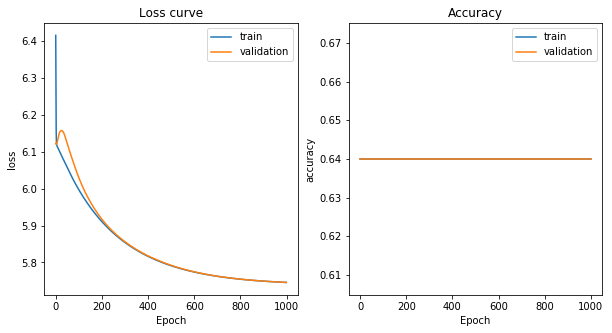

In [222]:
train_acc = history.history['acc']
valid_acc = history.history['val_acc']

# get the loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# get the number of entries
xvalues = np.arange(len(train_acc))

# visualize
f,ax = plot.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plot.show()

### Conclusion:

1. We got highest scores of ROC/AUC 0.92 in logistic regression with l2 parameter

2. From the learning curve, we also see that overfitting tendency is less


In [200]:
test_data = panda.read_csv('data/test.csv')

test_data_x = test_data[col_names]


In [214]:
test_target = model.predict(test_data_x)

In [215]:
test_target

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [211]:
np.bincount(test_target.astype(np.int64).ravel())


array([    0, 19750], dtype=int64)

In [213]:
final_submission = panda.DataFrame({'target':test_target.astype(np.int64).ravel()})
final_submission['id'] = test_data['id']
final_submission[['id','target']].head() 

# np.bincount(test_target)

final_submission[['id','target']].to_csv('sample_submission_keras.csv', index = False)